In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
trackdata ="../data/track_data/csvs/ARTHUR_2014.csv"
arthurdata = "http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/mab/Gridded/20140702T000000_20140707T000000_cinar_ru30.nc"

In [3]:
df = pd.read_csv(trackdata)
hurrlats, hurrlons = df['LAT'].values, df['LON'].values

hurrtnum = np.ones_like(hurrlats)
for i in range(len(hurrlats)):
    hdate = datetime.datetime.strptime(df['DATE'][i]+" "+df['ISO_TIME'][i], "%m/%d/%Y %H:%M:%S")
    hurrtnum[i] = mdates.date2num(hdate)

In [4]:
df = xr.open_dataset(arthurdata)

In [5]:
df

<xarray.Dataset>
Dimensions:      (depth: 60, profile: 730)
Coordinates:
    time         (profile) datetime64[ns] ...
  * depth        (depth) float64 -1.0 -3.0 -5.0 -7.0 ... -115.0 -117.0 -119.0
Dimensions without coordinates: profile
Data variables:
    latitude     (profile) float64 ...
    longitude    (profile) float64 ...
    temperature  (profile, depth) float64 ...
    salinity     (profile, depth) float64 ...
    OX           (profile, depth) float64 ...
    OXSAT        (profile, depth) float64 ...
    CDOM         (profile, depth) float64 ...
    CHLA         (profile, depth) float64 ...
    BB           (profile, depth) float64 ...
Attributes:
    Conventions:                     CF-1.0
    Title:                           Rutgers University COOL glider data on s...
    source:                          
    Institution:                     Institute for Marine and Coastal Science...
    history:                         Created by /home/om/cron/glider/glider_h...
    DODS_EXTRA.Unlimited_Dimension:  profile

In [6]:
df['mdate'] = mdates.date2num(df.time)

In [7]:
print(df.mdate.shape, df.depth.shape)

D, MDATE = np.meshgrid(df.depth.values,df.mdate.values)

(730,) (60,)


In [8]:
glats = np.squeeze(df.latitude.values)
glons = np.squeeze(df.longitude.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        latdist = glatitude - hlatitude
        londist = glons[i] - hurrlons[j]
        distance_metric[i,j] = np.sqrt(latdist**2 + londist**2)

b = np.amin(distance_metric)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrtnum[ktime]

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


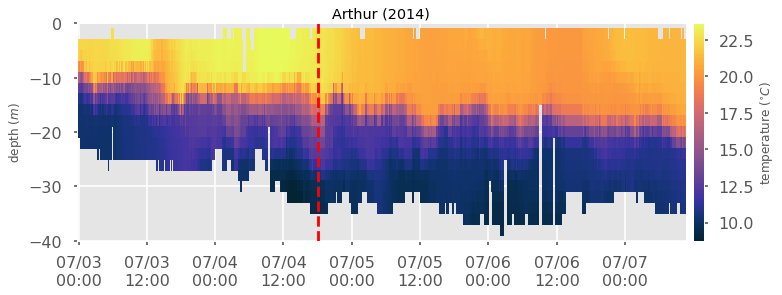

In [23]:
plt.figure(figsize=(13,4))
plt.pcolor(MDATE, D, df.temperature, cmap=cmo.thermal)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-40,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.title("Arthur (2014)")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.savefig("FIGS/temperatures_Arthur2014.pdf", bbox_inches='tight')
plt.grid()
plt.show()

In [10]:
bef = df.mdate.values < eyepassage-0.5
aft = df.mdate.values > eyepassage-2.5
qb   = np.logical_and(bef,aft)
temps_bef = df.temperature.values[qb,:3]
mean_Tbef = np.nanmean(temps_bef)

bef = df.mdate.values < eyepassage+(1/24)
aft = df.mdate.values > eyepassage-(1/24)
qeye  = np.logical_and(bef,aft)
temps_eye = df.temperature.values[qeye,:3]
mean_Teye = np.nanmean(temps_eye)

bef = df.mdate.values < eyepassage+0.5
aft = df.mdate.values > eyepassage+0.25
qa   = np.logical_and(bef,aft)
temps_aft = df.temperature.values[qa,:3]
mean_Taft = np.nanmean(temps_aft)

Ahead_of_eye_cooling = mean_Tbef - mean_Teye
After_of_eye_cooling = mean_Teye - mean_Taft

print(Ahead_of_eye_cooling, After_of_eye_cooling)

-0.28067591567260664 1.5652123321796125


In [11]:
dense0 = 1022.8
T0     = 17
S0     = 31.5
alpha  = 0.000281
beta   = 0.000766
g      = 9.81

dense = dense0 * (1 + alpha*(df.temperature.values-T0) + beta*(df.salinity.values-S0))
buoy  = -g * dense / dense0

dz = np.gradient(df.depth.values)
db = np.gradient(buoy, axis=[1])
dbdz = -db/dz

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


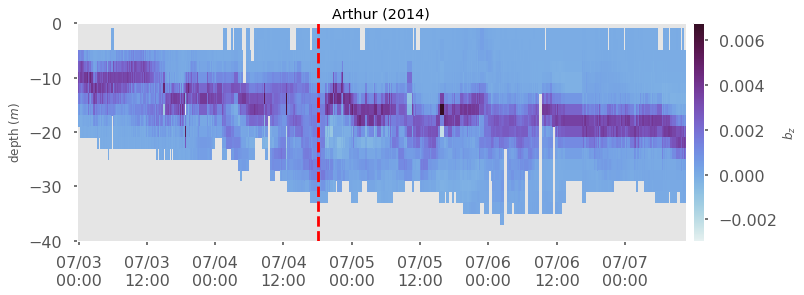

In [12]:
plt.figure(figsize=(13,4))
plt.pcolor(MDATE, D, dbdz, cmap=cmo.dense)
plt.colorbar(label='$b_z$',pad=0.01)
plt.ylim([-40,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.title("Arthur (2014)")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")

In [13]:
dbdz_b = dbdz[qb,:]
dbdz_b.shape
maxN2 = np.ones(dbdz_b.shape[0])
for i in range(dbdz_b.shape[0]):
    prof = dbdz_b[i,:]
    maxN2[i] = np.nanmax(prof)
    
np.nanmean(maxN2)

0.0032687698578709123

In [14]:
def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    new_d = np.arange(mindepth,maxdepth,0.1)
    y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
    new_tmp = y(new_d)
    tmp_low = np.abs(new_tmp - low)
    tmp_high = np.abs(new_tmp - high)
    q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
    q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
    #delta_d = new_d[q_high] - new_d[q_low]
    return new_d[q_high], new_d[q_low]

import scipy.interpolate as interp

low_depth  = np.ones_like(df['mdate'].values)
high_depth = np.ones_like(df['mdate'].values)

d = df.depth.values

for I in range(len(df['mdate'].values)):
    profile_tmp = df.temperature[I,:].values
    a, b = pycnocline_width(profile_tmp, d, low=13, high=17)
    if np.abs(a-b) < 0.25:
        low_depth[I], high_depth[I] = np.nan, np.nan
    else:
        low_depth[I], high_depth[I] = a, b

In [15]:
Pw_bef = np.nanmedian(low_depth[qb]-high_depth[qb])
Pw_eye = np.nanmedian(low_depth[qeye]-high_depth[qeye])
Pw_aft = np.nanmedian(low_depth[qa]-high_depth[qa])

Pw_bef, Pw_eye, Pw_aft, np.nanmean(high_depth[qb])-np.nanmean(high_depth[qeye])

(2.600000000000037, 6.100000000000087, 2.400000000000034, 7.621333333333309)

In [16]:
winddata = "../data/ndbc_years/44009h2014.txt"

In [17]:
ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)

In [18]:
list(ndb)

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'TIDE']

In [19]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
#ndb['datenum'] = ndb_datenum
start = mdates.date2num(datetime.datetime(2014,7,1))
enddd = mdates.date2num(datetime.datetime(2014,7,7))

In [20]:
wdir = ndb['WDIR']

In [22]:
eyepassage-3/24

16255.625

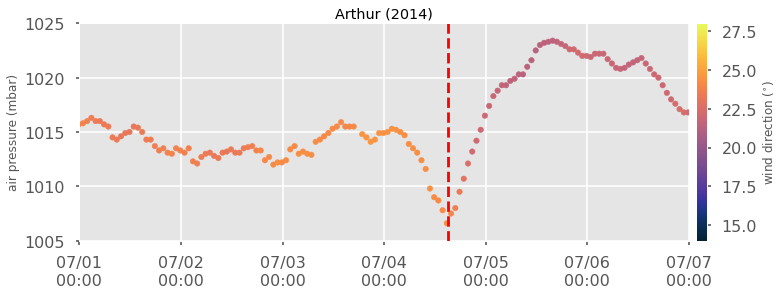

In [21]:
plt.figure(figsize=(13,4))
plt.scatter(ndb_datenum, ndb['PRES'], c=ndb['WTMP'], s=30, vmin=14, vmax=28, cmap='cmo.thermal')
plt.ylabel('air pressure (mbar)')
plt.colorbar(pad=0.01, label='wind direction ($^{\circ}$)')
plt.ylim([1005, 1025])
plt.xlim([start, enddd])
plt.title("Arthur (2014)")
plt.axvline(x = eyepassage-3/24, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)

In [27]:
eyeART = eyepassage-3/24

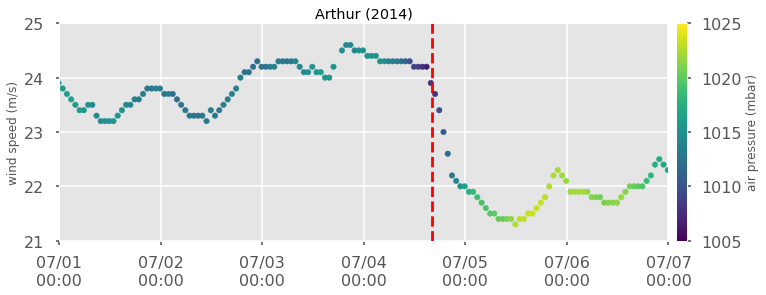

In [32]:
plt.figure(figsize=(13,4))
plt.scatter(ndb_datenum, ndb['WTMP'], c=ndb['PRES'], s=30, vmin=1005, vmax=1025, cmap='viridis')
plt.ylabel('wind speed (m/s)')
plt.colorbar(pad=0.01, label='air pressure (mbar)')
plt.ylim([21, 25])
plt.xlim([start, enddd])
plt.title("Arthur (2014)")
plt.axvline(x = eyepassage-1/12, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)

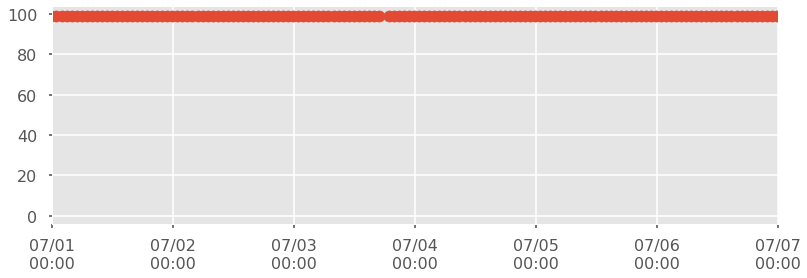

In [34]:
speed = np.squeeze(ndb['WSPD'])
ds    = np.gradient(speed)
q     = np.where(np.abs(ds) > 6)

ndnm = np.asarray(ndb_datenum)

speedgood = speed[np.abs(ds) < 1]
timegood  = ndnm[np.abs(ds) < 1]

plt.figure(figsize=(13,4))
plt.scatter(timegood, speedgood)
plt.xlim([start, enddd])
#plt.ylim([0,20])
plt.gca().xaxis.set_major_formatter(myFmt)

In [35]:
b44065 = "../data/ndbc_years/44065h2014.txt"
b44009 = "../data/ndbc_years/44009h2014.txt"

In [36]:
a = pd.read_csv(b44009, skiprows=[1], delim_whitespace=True)

In [37]:
length = len(a['#YY'])
bdnum  = np.ones(length)
for i in range(length):
    d = datetime.datetime(a['#YY'][i],a['MM'][i],a['DD'][i],a['hh'][i],a['mm'][i])
    bdnum[i] = mdates.date2num(d)

(16252.0, 16258.0)

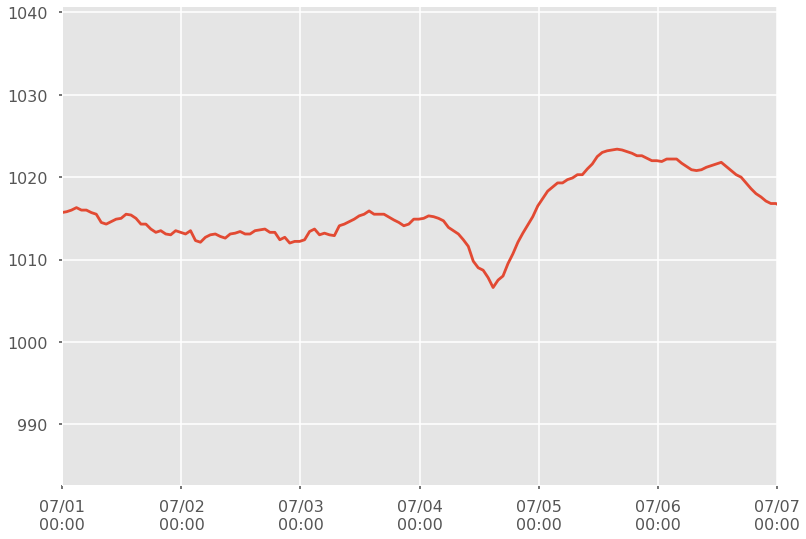

In [38]:
plt.plot(bdnum,a['PRES'])
myfmt2 = mdates.DateFormatter('%y/%m/%d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlim([start, enddd])

In [39]:
def cooling_defs_1D(datenums,eyepassage,wtemp):
    bef = datenums < eyepassage-0.5
    aft = datenums > eyepassage-2.0
    qb   = np.logical_and(bef,aft)
    temps_bef = wtemp[qb]
    mean_Tbef = np.nanmean(temps_bef)

    bef = datenums < eyepassage+(1/24)
    aft = datenums > eyepassage-(1/24)
    qeye  = np.logical_and(bef,aft)
    temps_eye = wtemp[qeye]
    mean_Teye = np.nanmean(temps_eye)

    bef = datenums < eyepassage+0.5
    aft = datenums > eyepassage+0.25
    qa   = np.logical_and(bef,aft)
    temps_aft = wtemp[qa]
    mean_Taft = np.nanmean(temps_aft)

    Ahead_of_eye_cooling = mean_Tbef - mean_Teye
    After_of_eye_cooling = mean_Teye - mean_Taft

    return(Ahead_of_eye_cooling, After_of_eye_cooling)

cooling_defs_1D(ndb_datenum,eyeART,ndb['WTMP'].values)

(0.1642857142857146, 2.0999999999999943)